In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sys

In [2]:
data_f = pd.read_csv('bitbootcamp/u.data',sep='\t',names=['userID','movieID','rating','timestamp'])

In [3]:
data_f.head(5)

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
#Checking no nulls for later aggregating
print len(data_f.dropna())

100000


In [5]:
temp1 = data_f[['userID','movieID']]

In [6]:
temp2 = pd.merge(temp1,temp1,on='movieID')

In [7]:
temp3 = temp2[temp2['userID_x']!=temp2['userID_y']]

In [8]:
temp4 = temp3.groupby(['userID_x','userID_y']).agg('count')

In [9]:
temp4.head(5)

movieID
userID_x userID_y         
1        2              18
         3               8
         4               7
         5              80
         6              96

In [10]:
print 'median: ',temp4['movieID'].median()
print 'mean: ',temp4['movieID'].mean()

median:  10.0
mean:  19.4672578127


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

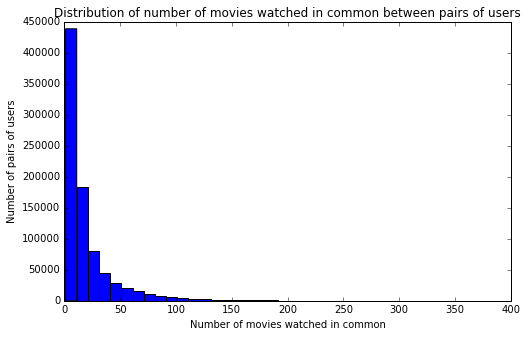

In [78]:
binwidth = 10
plt.figure(figsize=(8,5))
plt.hist(temp4['movieID'],bins=np.arange(min(temp4['movieID']), max(temp4['movieID']) + binwidth, binwidth))
plt.ylabel('Number of pairs of users')
plt.xlabel('Number of movies watched in common')
plt.title('Distribution of number of movies watched in common between pairs of users')
plt.savefig('bitbootcamp/pairgraph')

In [13]:
#Just checking that the aggregating worked
print temp4['movieID'].max()
print temp3['movieID'].max()

346
1672


In [14]:
#Maybe make a cut-off around 250-ish?
len(temp4[temp4['movieID']>250])

190

In [15]:
new = temp4[temp4['movieID']<=250]

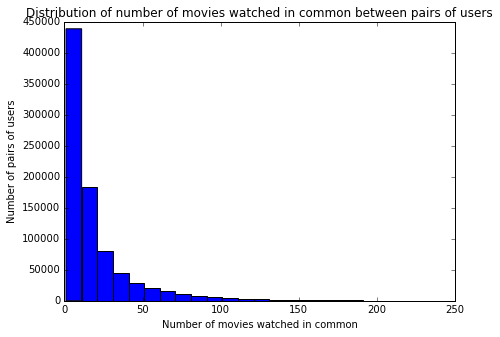

In [79]:
binwidth = 10
plt.figure(figsize=(7,5))
plt.hist(temp4['movieID'],bins=np.arange(min(new['movieID']), max(new['movieID']), binwidth))
plt.ylabel('Number of pairs of users')
plt.xlabel('Number of movies watched in common')
plt.title('Distribution of number of movies watched in common between pairs of users')
plt.savefig('bitbootcamp/pairgraph')

In [17]:
temp5 = data_f[['movieID']]
temp5['id2'] = temp5['movieID']

C:\Users\Robert\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
temp5.head()

,movieID,id2
0,242,242
1,302,302
2,377,377
3,51,51
4,346,346


In [19]:
temp6 = temp5.groupby('movieID').agg('count')['id2']

In [20]:
temp7 = temp6.sort_values(ascending=False)

In [21]:
print temp7.head(1)
print temp7.tail(1)

movieID
50    583
Name: id2, dtype: int64
movieID
1682    1
Name: id2, dtype: int64


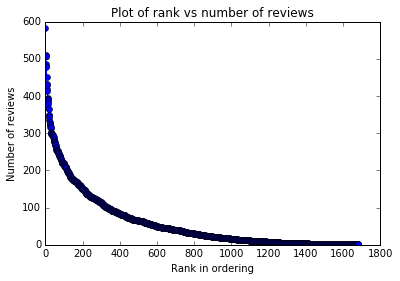

In [80]:
plt.plot(range(len(temp7)),temp7,'bo-')
plt.ylabel('Number of reviews')
plt.xlabel('Rank in ordering')
plt.title('Plot of rank vs number of reviews')
plt.savefig('bitbootcamp/zipf')

In [23]:
import scipy.stats as stat

In [24]:
a = np.array([5,5,1,1,1,3,3,3,3,3])
b = np.array([3,3,2,3,3,2,2,3,3,3])
c = np.array([5,4,3,2,3,3,3,3,3,3])

print stat.pearsonr(a,c)
print stat.pearsonr(b,c)
print np.sqrt(sum((a-c)**2))
print np.sqrt(sum((b-c)**2))

(0.80178372573727308, 0.0052761079358707398)
(0.17496355305594125, 0.62876990802279553)
3.16227766017
3.0


In [25]:
# 2a) I decide to use approach B, since approach A seems like the missing values could greatly skew if users have certain rating patterns (i.e. a high or low scorer)
# 

In [38]:
import scipy.stats as stat
import numpy as np
numOfUsers = 943
numOfItems = 1682

In [28]:
#Item based
file1 = 'bitbootcamp/u.data'
line_array = np.zeros((numOfItems,numOfUsers))

with open(file1,'rb') as infile:
    for line in infile.readlines():
        temp = line.split('\t')
        #First index is movieID, second is userID
        line_array[int(temp[1])-1][int(temp[0])-1] = int(temp[2])

In [53]:
#distance = 0
f = lambda x,y: stat.pearsonr(x,y)[0]
if distance == 0:
    f = lambda x,y: sum(abs(x-y))

In [54]:
iFlag = 0
movieid = 1
userid = 1
dist_array = np.array([])
for j in range(len(line_array)):
    #If the given user has not rated the movie
    if iFlag == 0 and line_array[j][userid-1] == 0:
        #append larger number than possible for distance
        dist_array=np.append(dist_array,(numOfUsers+5)*(numOfItems+5))
    else:
        dist_array=np.append(dist_array,f(line_array[movieid-1],line_array[j]))

In [55]:
dist_array

array([  0.00000000e+00,   1.54700000e+03,   1.60600000e+03, ...,
         1.59927600e+06,   1.59927600e+06,   1.59927600e+06])

In [56]:
k = 10
x=dist_array.argsort()
count = 0
pos = 0
#Will store the top k movie indices
topk = []
#Doing this because I am not sure whether or not the movieid will be in the array, and np.arrays do not have remove
while count < k:
    if x[pos] != movieid-1:
        topk.append(x[pos])
        count+=1
    pos+=1

In [57]:
scores = np.array([])
for item in topk:
    #Go to the 
    scores=np.append(scores,line_array[item][userid-1])
stat.mode(scores)[0][0]

4.0

In [26]:
def item_based_cf(datafile, userid, movieid, distance, k, iFlag, numOfUsers, numOfItems):
    '''
    build item-based collaborative filter that predicts the rating 
    of a user for a movie.
    This function returns the predicted rating and its actual rating.
    
    Parameters
    ----------
    <datafile> - a fully specified path to a file formatted like the MovieLens100K data file u.data 
    <userid> - a userId in the MovieLens100K data
    <movieid> - a movieID in the MovieLens 100K data set
    <distance> - a Boolean. If set to 0, use Pearson’s correlation as the distance measure. If 1, use Manhattan distance.
    <k> - The number of nearest neighbors to consider
    <iFlag> - A Boolean value. If set to 0 for user-based collaborative filtering, 
    only users that have actual (ie non-0) ratings for the movie are considered in your top K. 
    For item-based, use only movies that have actual ratings by the user in your top K. 
    If set to 1, simply use the top K regardless of whether the top K contain actual or filled-in ratings.

    returns
    -------
    trueRating: <userid>'s actual rating for <movieid>
    predictedRating: <userid>'s rating predicted by collaborative filter for <movieid>


    AUTHOR: Robert Tom
    '''
    #Store each item
    line_array = np.zeros((numOfItems,numOfUsers))

    with open(datafile,'rb') as infile:
        for line in infile.readlines():
            temp = line.split('\t')
            #First index is movieID, second is userID
            line_array[int(temp[1])-1][int(temp[0])-1] = int(temp[2])
    
    #Decide which distance measure to use
    f = lambda x,y: stat.pearsonr(x,y)[0]
    if distance == 0:
        f = lambda x,y: sum(abs(x-y))
            
    #Array of distances from given movie
    dist_array = np.array([])
    for j in range(len(line_array)):
        #If the given user has not rated the movie
        if iFlag == 0 and line_array[j][userid-1] == 0:
            #append larger number than possible for distance
            dist_array=np.append(dist_array,(numOfUsers+5)*(numOfItems+5))
        else:
            dist_array=np.append(dist_array,f(line_array[movieid-1],line_array[j]))

    x=dist_array.argsort()
    count = 0
    pos = 0
    #Will store the top k movie indices
    topk = []
    #Doing this because I am not sure whether or not the movieid will be in the array, and np.arrays do not have remove
    while count < k:
        if x[pos] != movieid-1:
            topk.append(x[pos])
            count+=1
        pos+=1
        
    scores = np.array([])
    for item in topk:
        #Go to the 
        scores=np.append(scores,line_array[item][userid-1])
    predictedRating = stat.mode(scores)[0][0]
    trueRating = line_array[movieid-1][userid-1]

    return trueRating, predictedRating



In [27]:
print item_based_cf('bitbootcamp/u.data',10,200,0,5,1,943,1682)
print item_based_cf('bitbootcamp/u.data',10,200,0,5,0,943,1682)

(5.0, 0.0)
(5.0, 4.0)


In [28]:
# Starter code for uesr-based collaborative filtering
# Complete the function user_based_cf below. Do not change it arguments and return variables. 
# Do not change main() function, 

# import modules you need here.
import sys


def user_based_cf(datafile, userid, movieid, distance, k, iFlag, numOfUsers, numOfItems):
    '''
    build user-based collaborative filter that predicts the rating 
    of a user for a movie.
    This function returns the predicted rating and its actual rating.
    
    Parameters
    ----------
    <datafile> - a fully specified path to a file formatted like the MovieLens100K data file u.data 
    <userid> - a userId in the MovieLens100K data
    <movieid> - a movieID in the MovieLens 100K data set
    <distance> - a Boolean. If set to 0, use Pearson’s correlation as the distance measure. If 1, use Manhattan distance.
    <k> - The number of nearest neighbors to consider
    <iFlag> - A Boolean value. If set to 0 for user-based collaborative filtering, 
    only users that have actual (ie non-0) ratings for the movie are considered in your top K. 
    For user-based, use only movies that have actual ratings by the user in your top K. 
    If set to 1, simply use the top K regardless of whether the top K contain actual or filled-in ratings.

    returns
    -------
    trueRating: <userid>'s actual rating for <movieid>
    predictedRating: <userid>'s rating predicted by collaborative filter for <movieid>


    AUTHOR: Robert Tom
    '''
  
    #Store each item
    line_array = np.zeros((numOfUsers,numOfItems))

    with open(datafile,'rb') as infile:
        for line in infile.readlines():
            temp = line.split('\t')
            #First index is movieID, second is userID
            line_array[int(temp[0])-1][int(temp[1])-1] = int(temp[2])
    
    #Decide which distance measure to use
    f = lambda x,y: stat.pearsonr(x,y)[0]
    if distance == 0:
        f = lambda x,y: sum(abs(x-y))
            
    #Array of distances from given movie
    dist_array = np.array([])
    for j in range(len(line_array)):
        #If the given user has not rated the movie
        if iFlag == 0 and line_array[j][movieid-1] == 0:
            #append larger number than possible for distance
            dist_array=np.append(dist_array,(numOfUsers+5)*(numOfItems+5))
        else:
            dist_array=np.append(dist_array,f(line_array[userid-1],line_array[j]))

    x=dist_array.argsort()
    count = 0
    pos = 0
    #Will store the top k movie indices
    topk = []
    #Doing this because I am not sure whether or not the movieid will be in the array, and np.arrays do not have remove
    while count < k:
        if x[pos] != userid-1:
            topk.append(x[pos])
            count+=1
        pos+=1
        
    scores = np.array([])
    for user in topk:
        #Go to the 
        scores=np.append(scores,line_array[user][movieid-1])
    predictedRating = stat.mode(scores)[0][0]
    trueRating = line_array[userid-1][movieid-1]

    return trueRating, predictedRating

In [29]:
print user_based_cf('bitbootcamp/u.data',10,200,0,5,1,943,1682)
print user_based_cf('bitbootcamp/u.data',10,200,0,5,0,943,1682)

(5.0, 0.0)
(5.0, 3.0)


In [30]:
import random as rd

samples = []
for i in range(50):
    #Chooses which 100 of the 100,000 ratings to use (by their order in u.data, rather than their values)
    temp = rd.sample(xrange(100000),100)
    
    #Get them in ascending order for ease of use
    temp.sort()
    
    samples.append(temp)

In [ ]:
############## NEED TO CREATE VARIANTS ON GIVEN FUNCTIONS TO MAKE THEM NOT USE SAMPLES

In [36]:
def test_item_based_cf(datafile, distance, k, iFlag, numOfUsers, numOfItems,samples,sample):
    '''
    build item-based collaborative filter that predicts the rating 
    of a user for a movie.
    This function returns the predicted rating and its actual rating.
    
    Parameters
    ----------
    <datafile> - a fully specified path to a file formatted like the MovieLens100K data file u.data 
    <userid> - a userId in the MovieLens100K data
    <movieid> - a movieID in the MovieLens 100K data set
    <distance> - a Boolean. If set to 0, use Pearson’s correlation as the distance measure. If 1, use Manhattan distance.
    <k> - The number of nearest neighbors to consider
    <iFlag> - A Boolean value. If set to 0 for user-based collaborative filtering, 
    only users that have actual (ie non-0) ratings for the movie are considered in your top K. 
    For item-based, use only movies that have actual ratings by the user in your top K. 
    If set to 1, simply use the top K regardless of whether the top K contain actual or filled-in ratings.

    returns
    -------
    trueRating: <userid>'s actual rating for <movieid>
    predictedRating: <userid>'s rating predicted by collaborative filter for <movieid>


    AUTHOR: Robert Tom
    '''
    #Store each item
    line_array = np.zeros((numOfItems,numOfUsers))
    
    count = 0
    index = 0
    movieid=0
    userid=0
    
    with open(datafile,'rb') as infile:
        for line in infile.readlines():
            temp = line.split('\t')
            # i.e. if the given line is one of our sample data
            if count < len(samples) and samples[count] == index:
                count+=1
                line_array[int(temp[1])-1][int(temp[0])-1] = 0
                #We get the true rating here since it won't be in the matrix
                if index == sample:
                    userid=int(temp[0])
                    movieid=int(temp[1])
                    trueRating = int(temp[2])
            else:
                #First index is movieID, second is userID
                line_array[int(temp[1])-1][int(temp[0])-1] = int(temp[2])
            index+=1

    
    #Decide which distance measure to use
    f = lambda x,y: stat.pearsonr(x,y)[0]
    if distance == 0:
        f = lambda x,y: sum(abs(x-y))
            
    #Array of distances from given movie
    dist_array = np.array([])
    for j in range(len(line_array)):
        #If the given user has not rated the movie
        if iFlag == 0 and line_array[j][userid-1] == 0:
            #append larger number than possible for distance
            dist_array=np.append(dist_array,(numOfUsers+5)*(numOfItems+5))
        else:
            dist_array=np.append(dist_array,f(line_array[movieid-1],line_array[j]))

    x=dist_array.argsort()
    count = 0
    pos = 0
    #Will store the top k movie indices
    topk = []
    #Doing this because I am not sure whether or not the movieid will be in the array, and np.arrays do not have remove
    while count < k:
        if x[pos] != movieid-1:
            topk.append(x[pos])
            count+=1
        pos+=1
        
    scores = np.array([])
    for item in topk:
        #Go to the 
        scores=np.append(scores,line_array[item][userid-1])
    predictedRating = stat.mode(scores)[0][0]
    #trueRating = line_array[movieid-1][userid-1]

    return trueRating, predictedRating

def test_user_based_cf(datafile, distance, k, iFlag, numOfUsers, numOfItems,samples,sample):
    '''
    build user-based collaborative filter that predicts the rating 
    of a user for a movie.
    This function returns the predicted rating and its actual rating.
    
    Parameters
    ----------
    <datafile> - a fully specified path to a file formatted like the MovieLens100K data file u.data 
    <userid> - a userId in the MovieLens100K data
    <movieid> - a movieID in the MovieLens 100K data set
    <distance> - a Boolean. If set to 0, use Pearson’s correlation as the distance measure. If 1, use Manhattan distance.
    <k> - The number of nearest neighbors to consider
    <iFlag> - A Boolean value. If set to 0 for user-based collaborative filtering, 
    only users that have actual (ie non-0) ratings for the movie are considered in your top K. 
    For user-based, use only movies that have actual ratings by the user in your top K. 
    If set to 1, simply use the top K regardless of whether the top K contain actual or filled-in ratings.

    returns
    -------
    trueRating: <userid>'s actual rating for <movieid>
    predictedRating: <userid>'s rating predicted by collaborative filter for <movieid>


    AUTHOR: Robert Tom
    '''
  
    #Store each item
    line_array = np.zeros((numOfUsers,numOfItems))
    
    index = 0
    count = 0
    movieid = 0
    userid = 0

    with open(datafile,'rb') as infile:
        for line in infile.readlines():
            temp = line.split('\t')
            
            # i.e. if the given line is one of our sample data
            if count < len(samples) and samples[count] == index:
                count+=1
                line_array[int(temp[0])-1][int(temp[1])-1] = 0
                #We get the true rating here since it won't be in the matrix
                if index == sample:
                    userid=int(temp[0])
                    movieid=int(temp[1])
                    trueRating = int(temp[2])
            else:
                #First index is movieID, second is userID
                line_array[int(temp[0])-1][int(temp[1])-1] = int(temp[2])
            index+=1
    
    #Decide which distance measure to use
    f = lambda x,y: stat.pearsonr(x,y)[0]
    if distance == 0:
        f = lambda x,y: sum(abs(x-y))
            
    #Array of distances from given movie
    dist_array = np.array([])
    for j in range(len(line_array)):
        #If the given user has not rated the movie
        if iFlag == 0 and line_array[j][movieid-1] == 0:
            #append larger number than possible for distance
            dist_array=np.append(dist_array,(numOfUsers+5)*(numOfItems+5))
        else:
            dist_array=np.append(dist_array,f(line_array[userid-1],line_array[j]))

    x=dist_array.argsort()
    count = 0
    pos = 0
    #Will store the top k movie indices
    topk = []
    #Doing this because I am not sure whether or not the movieid will be in the array, and np.arrays do not have remove
    while count < k:
        if x[pos] != userid-1:
            topk.append(x[pos])
            count+=1
        pos+=1
        
    scores = np.array([])
    for user in topk:
        #Go to the 
        scores=np.append(scores,line_array[user][movieid-1])
    predictedRating = stat.mode(scores)[0][0]
    #trueRating = line_array[userid-1][movieid-1]


    return trueRating, predictedRating

In [89]:
import time
Pears = []
for sample in samples:
    start = time.time()
    temp = map(lambda x: test_item_based_cf('bitbootcamp/u.data',0,10,0,numOfUsers,numOfItems,sample,x),sample)
    Pears.append(temp)
    print time.time()-start

116.112999916
109.872999907
116.860000134
112.45600009
114.828999996
111.864000082
110.453000069
110.66899991
117.619999886
112.40899992
110.552999973
111.955000162
110.371000051
111.812000036
116.145999908
117.150999784
113.052999973
105.156000137
108.187999964
106.276000023
123.457000017
110.399000168
106.712999821
108.27699995
111.291000128
97.2200000286
109.603999853
115.279000044
123.006000042
123.275000095
118.796000004
121.171000004
121.55099988
122.211999893
122.009000063
120.389999866
123.034999847
119.756000042
122.511999846
122.892999887
119.584000111
119.09800005
122.320999861
124.488999844
123.10800004
124.013000011
121.249000072
120.180000067
123.611999989
121.493000031


In [90]:
Mans = []
for sample in samples:
    start = time.time()
    temp = map(lambda x: test_item_based_cf('bitbootcamp/u.data',1,10,0,numOfUsers,numOfItems,sample,x),sample)
    Mans.append(temp)
    print time.time()-start

119.703000069
125.970999956
125.758999825
121.764999866
121.532000065
127.914000034
120.987999916
120.875999928
116.200000048
122.536000013
124.677999973
123.958999872
124.671000004
121.582999945
122.263000011
137.792000055
123.648000002
124.529000044
123.81099987
123.819999933
122.820999861
121.698000193
123.278000116
122.552999973
119.999000072
126.569000006
123.622999907
121.695999861
119.549000025
118.65899992
118.720999956
119.356999874
121.805000067
121.445999861
118.194999933
120.721999884
120.103000164
120.487999916
126.125
130.279999971
134.142999887
133.775000095
134.628999949
130.184000015
124.457000017
108.777999878
103.338999987
105.626000166
106.690000057
109.581999779


In [103]:
import pickle 

with open('Pears.pickle', 'wb') as handle:
  pickle.dump(Pears, handle)

with open('Mans.pickle', 'wb') as handle:
  pickle.dump(Mans, handle)

In [110]:
ar1 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),Pears)
ar2 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),Mans)

In [111]:
print np.mean(ar1),np.mean(ar2)

89.78 114.12


In [108]:
i1s = []
for sample in samples:
    start = time.time()
    temp = map(lambda x: test_user_based_cf('bitbootcamp/u.data',0,10,1,numOfUsers,numOfItems,sample,x),sample)
    i1s.append(temp)
    print time.time()-start

159.772000074
157.041000128
156.093999863
152.730999947
155.187000036
153.77699995
153.850000143
154.318000078
157.04399991
154.910000086
160.407999992
163.823999882
176.180999994
189.596999884
184.219000101
202.118000031
188.421000004
188.965999842
177.792000055
158.768000126
165.265999794
168.940000057
171.594000101
168.910000086
162.593000174
162.873999834
162.937000036
164.063000202
159.370999813
159.187999964
161.308000088
162.519999981
159.186000109
159.645999908
168.414000034
159.220999956
151.213999987
159.163000107
155.203999996
153.166999817
163.804000139
164.927000046
173.23300004
161.525000095
151.624000072
150.66899991
154.305000067
154.236000061
167.649999857
170.620000124


In [114]:
with open('i1s.pickle', 'wb') as handle:
    pickle.dump(i1s, handle)

In [115]:
ar3 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),i1s)

In [116]:
print np.mean(ar3)

336.4


In [117]:
ars = [[],[],[],[],[],[]]
for i,k in enumerate([1,2,4,8,16,32]):
    for sample in samples:
        temp = map(lambda x: test_user_based_cf('bitbootcamp/u.data',0,k,0,numOfUsers,numOfItems,sample,x),sample)
        ars[i].append(temp)
    with open('k'+str(k)+'.pickle', 'wb') as handle:
        pickle.dump(ars[i], handle)
    print k

1
2
4
8
16
32


In [118]:
for ar in ars:
    ar = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ar)
    print np.mean(ar)

104.98
114.34
103.2
93.88
90.6
93.04


In [131]:
print 't-test for k, only on nearest error'
print stat.ttest_rel( map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ars[4]),\
                      map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ars[5]))
print 't-test for distance'
print stat.ttest_rel(ar1,ar2)
print 't-test for iFlag'
print stat.ttest_rel(ar1,ar3)

t-test for k, only on nearest error
Ttest_relResult(statistic=-2.2242600383709203, pvalue=0.030770001374493761)
t-test for distance
Ttest_relResult(statistic=-16.487875826137561, pvalue=1.2430621262443123e-21)
t-test for iFlag
Ttest_relResult(statistic=-131.84869255000797, pvalue=3.5592043580406386e-64)


In [33]:
import pickle
import time

In [41]:
Items = []
for sample in samples:
    start = time.time()
    temp = map(lambda x: test_item_based_cf('bitbootcamp/u.data',0,16,0,numOfUsers,numOfItems,sample,x),sample)
    Items.append(temp)
    print time.time()-start

124.156999826
118.420000076
115.614000082
118.295000076
111.308000088
113.337000132
127.145000219
134.570999861
131.869999886
136.894000053
117.68599987
114.810000181
124.600999832
133.86500001
124.694999933
117.736000061
129.368999958
132.612999916
128.94299984
138.880999804
144.541000128
137.027999878
142.402999878
137.46600008
125.777000189
115.589999914
116.433999777
111.475999832
107.272000074
113.088999987
110.635999918
109.558000088
112.441999912
115.899000168
113.825000048
123.257999897
119.387000084
110.875
117.572000027
111.896999836
115.703999996
116.96600008
108.940000057
107.838999987
109.303999901
107.086000204
107.980999947
106.933000088
107.710000038
107.888999939


In [42]:
with open('Items.pickle', 'wb') as handle:
  pickle.dump(Items, handle)

In [43]:
Users = []
for sample in samples:
    start = time.time()
    temp = map(lambda x: test_user_based_cf('bitbootcamp/u.data',0,16,0,numOfUsers,numOfItems,sample,x),sample)
    Users.append(temp)
    print time.time()-start

110.766000032
108.904999971
107.41899991
108.843000174
107.619999886
108.752999783
108.654000044
110.437000036
107.759000063
108.103999853
109.196000099
107.450999975
110.259000063
110.440000057
111.247999907
108.792000055
109.150000095
110.006999969
110.570999861
109.274000168
108.608999968
108.381999969
107.953000069
108.722999811
109.925000191
109.019000053
109.875999928
110.638000011
108.625
108.302000046
110.150000095
109.314999819
108.566000223
110.215999842
111.9599998
109.248000145
108.5
109.91899991
110.559000015
109.552999973
107.534000158
110.822999954
111.958999872
107.604000092
109.029000044
109.155999899
109.75999999
107.546000004
111.354000092
110.088999987


In [44]:
with open('Users.pickle', 'wb') as handle:
  pickle.dump(Users, handle)

In [45]:
itemar = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),Items)
userar = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),Users)

In [46]:
print 't-test for item vs user'
print stat.ttest_rel(itemar,userar)

t-test for item vs user
Ttest_relResult(statistic=-1.7267948533856814, pvalue=0.090504636708728395)


In [47]:
print np.mean(itemar)
print np.mean(userar)

85.84
88.76


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

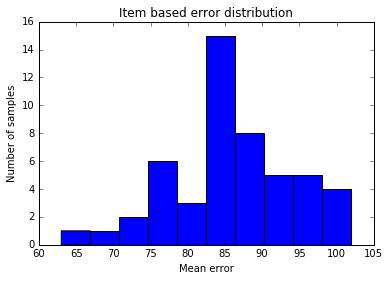

In [72]:
plt.hist(itemar)
plt.title('Item based error distribution')
plt.xlabel('Mean error')
plt.ylabel('Number of samples')
plt.savefig('bitbootcamp/itemgraph')

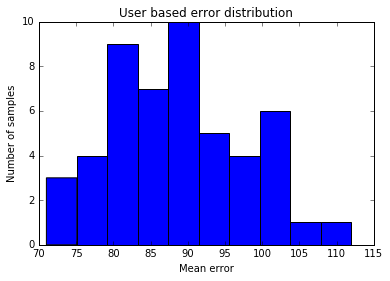

In [67]:
plt.hist(userar)
plt.title('User based error distribution')
plt.xlabel('Mean error')
plt.ylabel('Number of samples')
plt.savefig('bitbootcamp/usergraph')

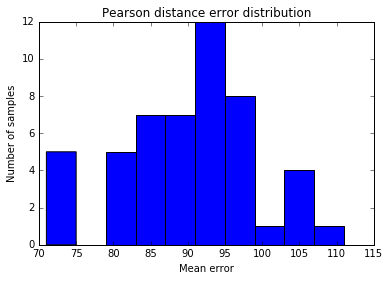

In [68]:
ar1 = pickle.load(open('Pears.pickle','rb'))
ar1 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ar1)
plt.hist(ar1)
plt.title('Pearson distance error distribution')
plt.xlabel('Mean error')
plt.ylabel('Number of samples')
plt.savefig('bitbootcamp/Pearsgraph')

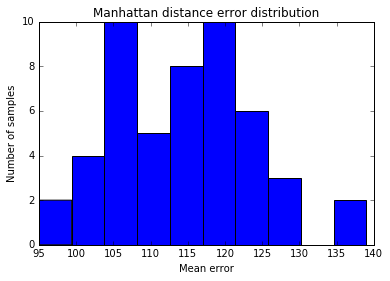

In [69]:
ar2 = pickle.load(open('Mans.pickle','rb'))
ar2 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ar2)
plt.hist(ar2)
plt.title('Manhattan distance error distribution')
plt.xlabel('Mean error')
plt.ylabel('Number of samples')
plt.savefig('bitbootcamp/Mansgraph')

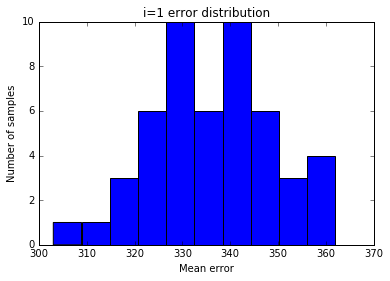

In [70]:
ar3 = pickle.load(open('i1s.pickle','rb'))
ar3 = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ar3)
plt.hist(ar3)
plt.title('i=1 error distribution')
plt.xlabel('Mean error')
plt.ylabel('Number of samples')
plt.savefig('bitbootcamp/i1sgraph')

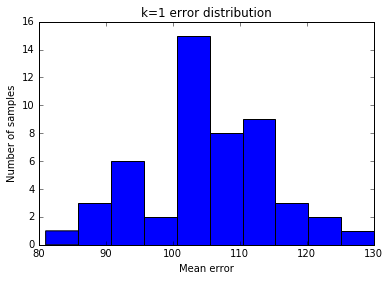

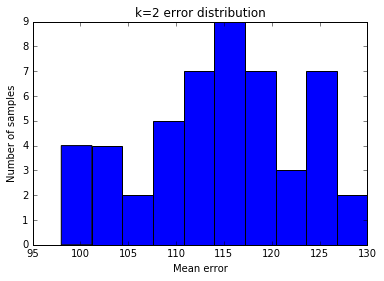

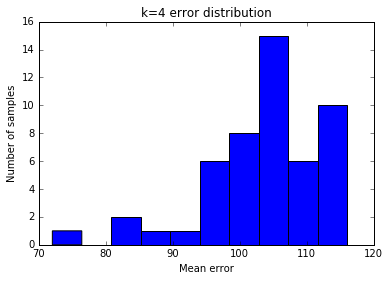

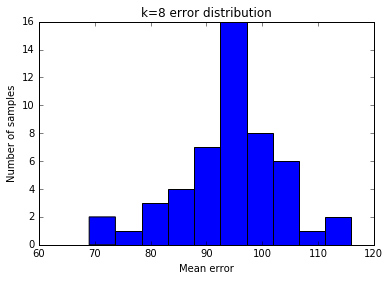

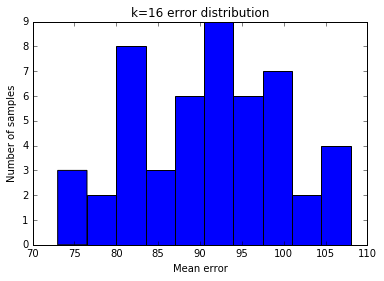

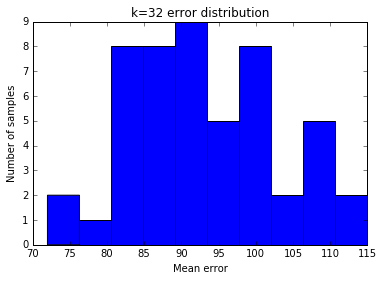

In [71]:
for k in [1,2,4,8,16,32]:
    ar = pickle.load(open('k'+str(k)+'.pickle','rb'))
    ar = map(lambda x: sum(map(lambda y: abs(y[0]-y[1]),x)),ar)
    plt.hist(ar)
    plt.title('k='+str(k)+' error distribution')
    plt.xlabel('Mean error')
    plt.ylabel('Number of samples')
    plt.savefig('bitbootcamp/k'+str(k)+'graph')
    plt.show()